In [1]:
# @title Download .npy & .npz Dataset

import concurrent.futures
import os
import xml.etree.ElementTree as ET

import requests

# Shared class names (without extension, to be extended based on type)
base_classes = [
    "backpack",
    "banana",
    "bat",
    "beard",
    "bicycle",
    "bird",
    "book",
    "bread",
    "bridge",
    "bucket",
    "bush",
    "butterfly",
    "cactus",
    "camel",
    "camera",
    "candle",
    "cow",
    "crab",
    "crown",
    "cup",
    "donut",
    "dumbbell",
    "elbow",
    "eye",
    "fish",
    "flashlight",
    "flip flops",
    "flower",
    "foot",
    "hat",
    "helicopter",
    "hot air balloon",
    "leaf",
    "leg",
    "light bulb",
    "lightning",
    "motorbike",
    "mouth",
    "nail",
    "pencil",
    "pillow",
    "river",
    "school bus",
    "sock",
    "spoon",
    "table",
    "telephone",
    "tooth",
    "tree",
    "umbrella",
]


def fetch_xml(xml_url):
    response = requests.get(xml_url)
    if response.status_code != 200:
        print(f"[ERROR] Failed to fetch XML: {response.status_code}")
        return None
    return response.content


def parse_xml(xml_content, selected_files, prefix_filter):
    root = ET.fromstring(xml_content)
    namespace = {"s3": "http://doc.s3.amazonaws.com/2006-03-01"}
    base_url = "https://storage.googleapis.com/quickdraw_dataset/"
    file_urls = []

    for content in root.findall(".//s3:Contents", namespace):
        key = content.find("s3:Key", namespace).text
        file_name = os.path.basename(key)

        if prefix_filter and not key.startswith(prefix_filter):
            continue
        if file_name in selected_files:
            file_urls.append(base_url + key)
    return file_urls


def download_file(file_url, download_folder):
    file_path = os.path.join(download_folder, os.path.basename(file_url))
    if os.path.exists(file_path):
        print(f"[SKIP] Already exists: {file_path}")
        return
    print(f"[DOWNLOAD] {file_url}")
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
    else:
        print(
            f"[FAIL] Could not download: {file_url} - Status code: {response.status_code}"
        )


def download_quickdraw_files(
    xml_url, download_folder, file_type="npy", prefix_filter=""
):
    selected_files = [name + f".{file_type}" for name in base_classes]

    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    xml_content = fetch_xml(xml_url)
    if xml_content is None:
        return

    file_urls = parse_xml(xml_content, selected_files, prefix_filter)

    print(f"[INFO] Downloading {len(file_urls)} files to '{download_folder}'")
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(lambda url: download_file(url, download_folder), file_urls)


# Download image .npy files
download_quickdraw_files(
    xml_url="https://storage.googleapis.com/quickdraw_dataset/",
    download_folder="image_folder",
    file_type="npy",
    prefix_filter="",
)

# Download stroke .npz files
download_quickdraw_files(
    xml_url="https://storage.googleapis.com/quickdraw_dataset?prefix=sketchrnn/",
    download_folder="strokes_data",
    file_type="npz",
    prefix_filter="sketchrnn/",
)

[INFO] Downloading 50 files to 'image_folder'
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/backpack.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bat.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/beard.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bicycle.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bread.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bridge.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bucket.npy
[DOWNLOAD] https://storage.googleapis.com/quickdraw_dataset/full/numpy

In [2]:
# all import necesary
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (
    Bidirectional,
    Input,
    LSTM,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Concatenate,
)
from tensorflow.keras.models import Model

2025-06-11 06:02:41.943103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749621762.148102      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749621762.208427      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Global Settings

MAX_SEQ_LEN = 130
STROKE_FEATURES = 3
IMG_HEIGHT, IMG_WIDTH = 28, 28
IMG_CHANNELS = 1
NUM_CLASSES = 50
SAMPLES_PER_CLASS = 5000
DATA_DIR_STROKES = "strokes_data"
DATA_DIR_IMAGES = "image_folder"
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 20

In [5]:
# def preprocess_stroke(stroke, max_len=MAX_SEQ_LEN):
#     stroke = stroke.astype(np.float32)
#     stroke[:, 0] = np.cumsum(stroke[:, 0])  # make x like absolute from delta
#     stroke[:, 1] = np.cumsum(stroke[:, 1])  # same do for y also
#     stroke[:, 0] -= stroke[:, 0].mean()  # center x to 0
#     stroke[:, 1] -= stroke[:, 1].mean()  # center y to 0 again
#     if len(stroke) > max_len:
#         return stroke[:max_len]  # if too long, cut itt
#     pad = np.zeros((max_len - len(stroke), STROKE_FEATURES), dtype=np.float32)
#     return np.vstack([stroke, pad])  # else just fill with zero

def preprocess_stroke(stroke, max_len=MAX_SEQ_LEN):
    """
    Improved stroke preprocessing with consistent normalization
    Centers to (0,0) and scales to [-100, 100] range
    """
    stroke = stroke.astype(np.float32)
    
    # Convert to absolute coordinates
    stroke[:, 0] = np.cumsum(stroke[:, 0])
    stroke[:, 1] = np.cumsum(stroke[:, 1])
    
    # Center to (0, 0)
    stroke[:, 0] -= stroke[:, 0].mean()
    stroke[:, 1] -= stroke[:, 1].mean()
    
    # Scale to [-100, 100] range
    if len(stroke) > 0:
        # Find the maximum absolute coordinate value
        max_coord = max(
            np.abs(stroke[:, 0]).max() if len(stroke) > 0 else 1,
            np.abs(stroke[:, 1]).max() if len(stroke) > 0 else 1
        )
        
        # Avoid division by zero
        if max_coord > 0:
            # Scale to [-100, 100] range
            scale_factor = 100.0 / max_coord
            stroke[:, 0] *= scale_factor
            stroke[:, 1] *= scale_factor
    
    # Truncate or pad as before
    if len(stroke) > max_len:
        return stroke[:max_len]
    
    pad = np.zeros((max_len - len(stroke), STROKE_FEATURES), dtype=np.float32)
    return np.vstack([stroke, pad])


In [6]:
    def load_hybrid_data(N=SAMPLES_PER_CLASS):
        img_files_full = sorted(
            f for f in os.listdir(DATA_DIR_IMAGES) if f.endswith(".npy")
        )
        stroke_files_full = sorted(
            f for f in os.listdir(DATA_DIR_STROKES) if f.endswith(".npz")
        )
        
        img_names = {os.path.splitext(f)[0] for f in img_files_full}
        stroke_names = {os.path.splitext(f)[0] for f in stroke_files_full}
        common = sorted(img_names & stroke_names)[:NUM_CLASSES]
    
        X_img_list, X_str_list, y_list = [], [], []
        for idx, cls in enumerate(common):
            img_arr = np.load(
                os.path.join(DATA_DIR_IMAGES, f"{cls}.npy"),
                allow_pickle=True,
                encoding="latin1",
            )[:N]
            img_arr = (
                img_arr.reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS).astype("float32")
                / 255.0
            )
            X_img_list.append(img_arr)
    
            data = np.load(
                os.path.join(DATA_DIR_STROKES, f"{cls}.npz"),
                allow_pickle=True,
                encoding="latin1",
            )
            strokes = data["train"][:N]
            proc = np.stack([preprocess_stroke(s) for s in strokes], axis=0)
            X_str_list.append(proc)
    
            y_list.append(
                np.full((N,), idx, dtype=np.int32)
            )  #  putting labels same for each class
    
        X_img = np.concatenate(X_img_list, axis=0)
        X_str = np.concatenate(X_str_list, axis=0)
        y = np.concatenate(y_list, axis=0)
        X_img, X_str, y = shuffle(
            X_img, X_str, y, random_state=42
        )  #  mix everything randomly
    
        true_num_classes = len(common)
        y_cat = to_categorical(y, num_classes=true_num_classes)
        return (X_str, X_img), y_cat


In [7]:
def build_hybrid_model():
    # Stroke input branch: captures temporal dependency of pen stokes using  Bidirectional LSTMs
    inp_str = Input(shape=(MAX_SEQ_LEN, STROKE_FEATURES), name="stroke_input")
    x = Bidirectional(LSTM(128, return_sequences=True))(inp_str)
    x = Bidirectional(LSTM(64))(x)
    x = Dense(64, activation="relu")(
        x
    )  # Dense layer to compact learned stroke features

    # Image input branch: processes sketch image using a CNN to extract spatial patterns
    inp_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="image_input")
    y = Conv2D(32, 3, activation="relu", padding="same")(inp_img)
    y = MaxPooling2D()(y)
    y = Conv2D(64, 3, activation="relu", padding="same")(y)
    y = MaxPooling2D()(y)
    y = Conv2D(128, 3, activation="relu", padding="same")(y)
    y = MaxPooling2D()(y)
    y = Flatten()(y)
    y = Dense(128, activation="relu")(y)

    # Feature fusion: concatenate outputs from stroke and image branches
    merged = Concatenate()([x, y])
    merged = Dropout(0.5)(merged)  # dropout
    merged = Dense(128, activation="relu")(merged)
    out = Dense(NUM_CLASSES, activation="softmax")(merged)

    return Model(inputs=[inp_str, inp_img], outputs=out, name="hybrid_model")


# Training

In [8]:
# load data
(X_str, X_img), y = load_hybrid_data(N=SAMPLES_PER_CLASS)
NUM_CLASSES = y.shape[1]
total = X_img.shape[0]
split = int((1 - VALIDATION_SPLIT) * total)

# trian test split
X_str_train, X_str_val = X_str[:split], X_str[split:]
X_img_train, X_img_val = X_img[:split], X_img[split:]
y_train, y_val = y[:split], y[split:]


In [9]:
# build and trian model
model = build_hybrid_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

I0000 00:00:1749621825.822068      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749621825.822714      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "hybrid_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 14, 14, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 7, 7, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stroke_input (InputLayer) │ (None, 130, 3)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 130, 256)       │        135,168 │ stroke_input[0][0]     │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 3, 3, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1152)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │        147,584 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 192)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         24,704 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 579,186 (2.21 MB)

 Trainable params: 579,186 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    ModelCheckpoint(
        "best_hybrid_model_strokes_scaled.keras", monitor="val_accuracy", save_best_only=True
    ),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

history = model.fit(
    [X_str_train, X_img_train],
    y_train,
    validation_data=([X_str_val, X_img_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/20


I0000 00:00:1749621967.838928     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.4721 - loss: 1.8863 - val_accuracy: 0.8514 - val_loss: 0.4976
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.7850 - loss: 0.7049 - val_accuracy: 0.8880 - val_loss: 0.3652
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.8340 - loss: 0.5410 - val_accuracy: 0.9061 - val_loss: 0.3023
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.8598 - loss: 0.4563 - val_accuracy: 0.9150 - val_loss: 0.2734
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step - accuracy: 0.8765 - loss: 0.4018 - val_accuracy: 0.9112 - val_loss: 0.2860
Epoch 6/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.8872 - loss: 0.3663 - val_accuracy: 0.9243 - val_loss: 0.2483
Epoch 7/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.8977 - loss: 0.3308 - val_accuracy: 0.9274 - val_loss: 0.2361
Epoch 8/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.9034 - loss: 0.30

# Plots

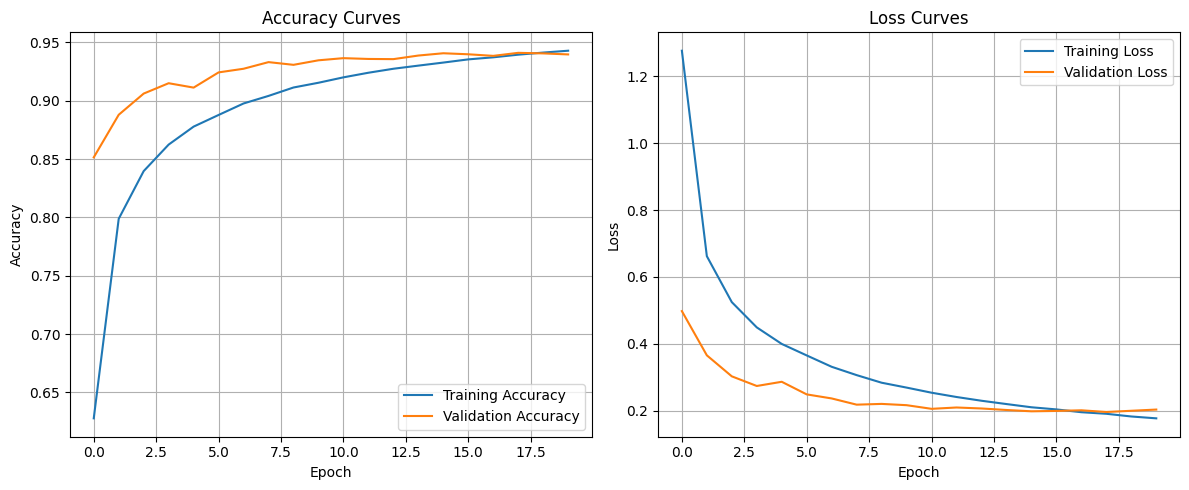

In [20]:
# plots accruacy and  losss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


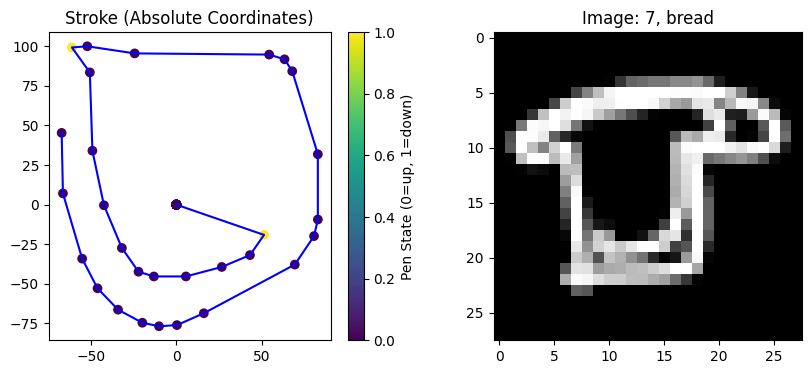

In [21]:
import matplotlib.pyplot as plt

idx = 0

label = base_classes[np.argmax(y[idx])]

# Plot a stroke (first sample)
stroke = X_str[idx]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Stroke (Absolute Coordinates)")
plt.plot(stroke[:, 0], stroke[:, 1], 'b-')  # Plot x/y
plt.scatter(stroke[:, 0], stroke[:, 1], c=stroke[:, 2], cmap='viridis')  # Color by pen state
plt.colorbar(label='Pen State (0=up, 1=down)')

# Plot corresponding image (first sample)
plt.subplot(1, 2, 2)
plt.title(f"Image: {np.argmax(y[idx])}, {label}")
plt.imshow(X_img[idx].squeeze(), cmap='gray')  # Remove channel dim for plotting
plt.show()

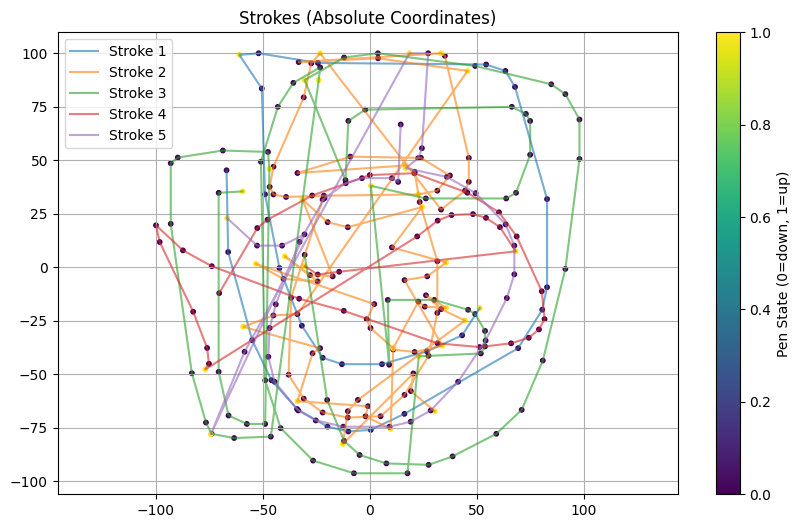

In [22]:
# Plot a few strokes to observe

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.title("Strokes (Absolute Coordinates)")

for i, stroke in enumerate(X_str[:5]):
    valid_mask = np.any(stroke != 0, axis=1)
    stroke = stroke[valid_mask]
    plt.plot(stroke[:, 0], stroke[:, 1], alpha=0.6, label=f'Stroke {i+1}')
    plt.scatter(stroke[:, 0], stroke[:, 1], c=stroke[:, 2], cmap='viridis', s=10)

plt.colorbar(label='Pen State (0=down, 1=up)')
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

# Observations
# 1. Strokes are absolute
# 2. Strokes are centered to (0, 0)
# 3. Except a few outliers range it fixed (This will cause problems, 
#    even if I get the strokes to be exactly same, a slight scaling may throw off results)

# Inference

In [19]:
# testing with random 50 examples to see inference

import time

model.load_weights("best_hybrid_model.keras")

num_test = 50
test_str = X_str_val[:num_test]
test_img = X_img_val[:num_test]

start = time.time()
preds = model.predict([test_str, test_img])
end = time.time()

pred_cl = np.argmax(preds, axis=1)
true_cl = np.argmax(y_val[:num_test], axis=1)

print("Predicted classes:", [LABELS[i] for i in pred_cl])
print("True classes:     ", [LABELS[i] for i in true_cl])

print(f"Inference time for {num_test} samples: {end - start:.4f} seconds")
print(f"Average time per sample: {(end - start) / num_test:.6f} seconds")


FileNotFoundError: [Errno 2] No such file or directory: 'best_hybrid_model.keras'